# Capstone - Seattle Airbnb Data (June, 2009 - August, 2016)

* Student name: Andrew Wester
* Student pace: Full Time
* Scheduled project review date/time: Thursday, March 28, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import folium
from folium import plugins
import os
import shutil
from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore')

#!pip install jupyternotify
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
## Run %%notify to create notification for completed cell

<IPython.core.display.Javascript object>

In [15]:
calendar = pd.read_csv('Data/seattle_airbnb/calendar.csv', parse_dates=[1])
listings = pd.read_csv('Data/seattle_airbnb/listings.csv')
reviews = pd.read_csv('Data/seattle_airbnb/reviews.csv', parse_dates=[2])

In [16]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [17]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [19]:
worthless_info = listings[['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
                           'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
                           'neighbourhood_group_cleansed', 'country_code', 'country', 'is_location_exact',
                           'calendar_last_scraped', 'license', 'jurisdiction_names', 'square_feet',
                           'notes', 'neighborhood_overview']]
host_info = listings[['host_id', 'host_url', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                      'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count',
                      'host_verifications', 'host_has_profile_pic', 'host_identity_verified']]

In [20]:
drop = pd.concat([worthless_info, host_info], axis=1)
drop = drop.columns
drop

Index(['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'country_code', 'country',
       'is_location_exact', 'calendar_last_scraped', 'license',
       'jurisdiction_names', 'square_feet', 'notes', 'neighborhood_overview',
       'host_id', 'host_url', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified'],
      dtype='object')

In [21]:
listings = listings.drop(drop, axis=1)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [22]:
listings.isna().sum()

id                                     0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
transit                              934
host_name                              2
host_total_listings_count              2
street                                 0
neighbourhood                        416
city                                   0
state                                  0
zipcode                                7
market                                 0
smart_location                         0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             16
bedrooms                               6
beds                                   1
bed_type        

In [23]:
listings['price'] = listings['price'].fillna('$0.00')
listings['price'] = listings['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

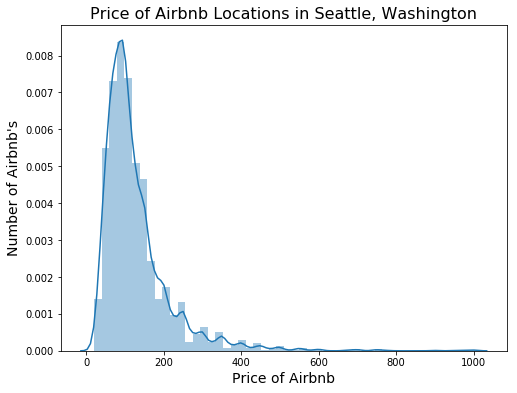

In [41]:
plt.figure(figsize=(8, 6))
# plt.hist(listings.price)
sns.distplot(listings.price)
plt.xlabel('Price of Airbnb', fontsize=14)
plt.ylabel("Number of Airbnb's", fontsize=14)
plt.title('Price of Airbnb Locations in Seattle, Washington', fontsize=16)
plt.show()

In [81]:
listings.review_scores_rating.dropna(inplace=True)

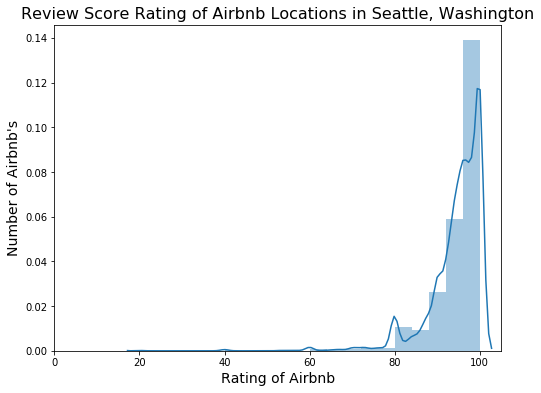

In [89]:
plt.figure(figsize=(8, 6))
sns.distplot(listings.review_scores_rating, bins=20)
plt.xlabel('Rating of Airbnb', fontsize=14)
plt.xlim(0, 105)
plt.ylabel("Number of Airbnb's", fontsize=14)
plt.title('Review Score Rating of Airbnb Locations in Seattle, Washington', fontsize=16)
plt.show()

In [79]:
listings.review_scores_rating.describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

In [42]:

reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [43]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [46]:
marks = listings[['latitude', 'longitude', 'id', 'price', 'property_type', 'bedrooms', 'bathrooms']]
marks['property_type'] = marks['property_type'].replace({'Townhouse': 'Other', 
                                                         'Bungalow': 'Other',
                                                         'Condominium': 'Other', 
                                                         'Camper/RV': 'Other',
                                                         'Cabin': 'Other'})
marks.head()

,latitude,longitude,id,price,property_type,bedrooms,bathrooms
0,47.636289,-122.371025,241032,85.0,Apartment,1.0,1.0
1,47.639123,-122.365666,953595,150.0,Apartment,1.0,1.0
2,47.629724,-122.369483,3308979,975.0,House,5.0,4.5
3,47.638473,-122.369279,7421966,100.0,Apartment,0.0,1.0
4,47.632918,-122.372471,278830,450.0,House,3.0,2.0


In [47]:
locations = marks[['latitude', 'longitude']]
locationlist = locations.values.tolist()
print(len(locationlist))
locationlist[:5]

3818


[[47.636289038357184, -122.37102519997765],
 [47.63912312136253, -122.36566646439582],
 [47.629724131577355, -122.3694831756176],
 [47.63847320176642, -122.36927912263019],
 [47.63291840276724, -122.37247063402224]]

In [48]:
marks.loc[1]

latitude           47.6391
longitude         -122.366
id                  953595
price                  150
property_type    Apartment
bedrooms                 1
bathrooms                1
Name: 1, dtype: object

In [55]:
# if not os.path.exists('Maps/airbnb_cluster1.html'):
clusters= folium.Map(location=[47.6062, -122.3321],
                    zoom_start = 11)
plugins.MarkerCluster(locationlist).add_to(clusters)
plugins.ScrollZoomToggler().add_to(clusters)
#     clusters.save(os.path.join('Maps/', 'airbnb_cluster1.html'))
clusters

In [100]:
#if(not os.path.exists('Maps/airbnb_ind_1.html')):
airbnb_map=folium.Map(location=[listings.latitude.mean(),listings.longitude.mean()],
                      zoom_start=11,tiles='OpenStreetMap')
for point in np.random.randint(0, len(locationlist), 100):
    folium.Marker(locationlist[point]).add_to(airbnb_map)
plugins.ScrollZoomToggler().add_to(airbnb_map)
airbnb_map.save(os.path.join('Maps/', 'airbnb_ind_1.html'))
airbnb_map

In [17]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [19]:
reviews_list = listings[['id', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [20]:
reviews_list.head()

,id,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3308979,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,7421966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,92.0,9.0,9.0,10.0,10.0,9.0,9.0


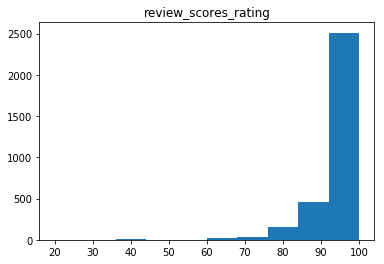

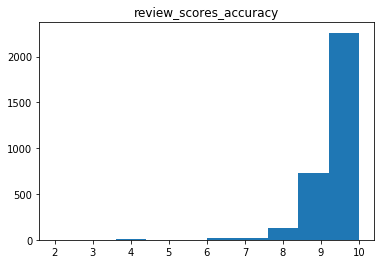

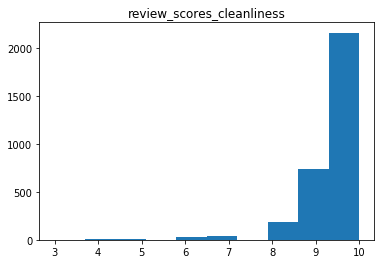

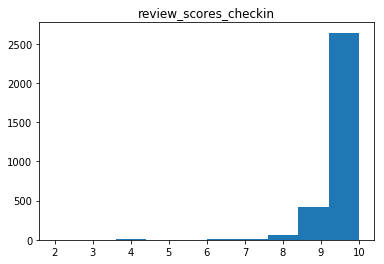

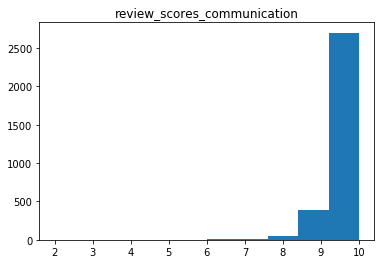

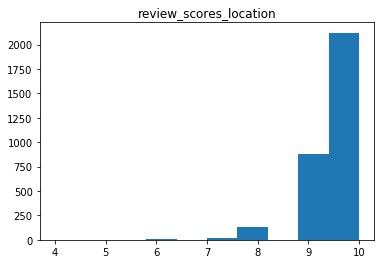

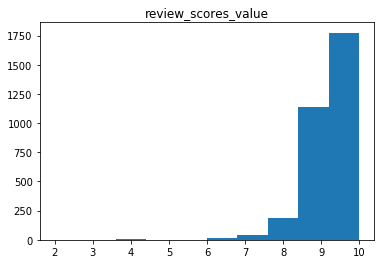

In [21]:
cols = reviews_list.columns[1:]
for col in cols:
    plt.figure()
    plt.hist(reviews_list[col].values)
    plt.title(str(col))

In [22]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [23]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [24]:
calendar.price.dropna(inplace=True)

In [67]:
calendar['available'].replace({'t': True, 'f': False}, inplace=True)

In [26]:
#calendar['price'] = calendar['price'].fillna('$0.00')

In [27]:
#calendar['price'] = calendar['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

In [68]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,$85.00
1171285,7109735,2016-01-04,False,NaN
442380,5736082,2016-01-04,False,NaN
997180,7435912,2016-01-04,True,$70.00
1203040,1777158,2016-01-04,False,NaN


In [69]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         934542 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 43.9+ MB


In [70]:
calendar.sort_values(by='date', inplace=True)

In [72]:
calendar[calendar['available'] == True].count()

listing_id    934542
date          934542
available     934542
price         934542
dtype: int64

In [73]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [77]:
calendar.date.describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

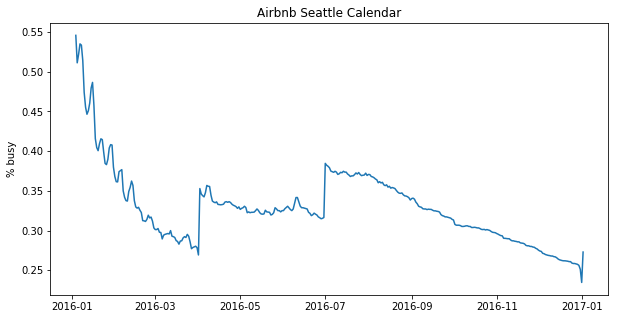

In [75]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == True else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Seattle Calendar')
plt.ylabel('% busy')
plt.show();

In [34]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         934542 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(1)
memory usage: 43.9+ MB


In [35]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [36]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [37]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


# Analyze Text Data from Listings and Reviews

In [38]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [39]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [40]:
listings_text = listings[['name', 'summary', 'space', 'description', 'transit', 'amenities']]

In [41]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [42]:
reviews.rename(index=str, columns={"id": "review_id"}, inplace=True)

In [43]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
review_id        84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


In [44]:
reviews.listing_id.nunique()

3191

In [45]:
reviews.dropna(inplace=True)

In [46]:
ids = list(reviews.listing_id.unique())

In [47]:
review_dict = {}
for i in ids:
    df = reviews.loc[reviews['listing_id'] == i]
    review_dict[i] = {}
    review_dict[i]['reviewer_id'] = (df['reviewer_id'])
    review_dict[i]['reviewer'] = (df['reviewer_name'])
    review_dict[i]['comments'] = (df['comments'])

In [48]:
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [50]:
reviews.fillna('', inplace=True)

In [51]:
reviews.isna().sum()

listing_id       0
review_id        0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [52]:
reviews_text = list(reviews.comments)
all(type(r)==str for r in reviews_text)
for r in reviews_text:
    if type(r) == str:
        continue
    else:
        print(r)
        print(type(r))
        print("-"*50)
        print("\n")

In [53]:
all(type(r)==str for r in reviews_text)

True

In [54]:
reviews_text

['Cute and cozy place. Perfect location to everything! ',
 'Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.',
 'Very spacious apartment, and in a great neighborhood.  This is the kind of apartment I wish I had!\r\n\r\nDidn\'t really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only "issue" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday',
 "Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the

In [55]:
start = timer()
tokens = reviews['comments'].apply(word_tokenize)
end = timer()
print(abs(end - start))
%notify

53.085306639


<IPython.core.display.Javascript object>

In [56]:
tokens

0        [Cute, and, cozy, place, ., Perfect, location,...
1        [Kelly, has, a, great, room, in, a, very, cent...
2        [Very, spacious, apartment, ,, and, in, a, gre...
3        [Close, to, Seattle, Center, and, all, it, has...
4        [Kelly, was, a, great, host, and, very, accomm...
5        [Kelly, was, great, ,, place, was, great, ,, j...
6        [Kelly, was, great, !, Very, nice, and, the, n...
7        [hola, all, bnb, erz, -, Just, left, Seattle, ...
8        [Kelly, 's, place, is, conveniently, located, ...
9        [The, place, was, really, nice, ,, clean, ,, a...
10       [The, place, was, really, nice, ,, clean, and,...
11       [The, listing, was, exactly, as, described, !,...
12       [Very, welcoming, and, a, nicer, place, to, li...
13       [Great, location, ,, great, price, ,, great, h...
14       [Staying, at, Kelly, 's, was, easy, ., The, lo...
15       [Kelly, was, an, amazing, host, who, made, the...
16       [Despite, our, late, booking, request, ,, Rach.

# Sentiment Intensity Analysis of Reiews

In [57]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import nltk.sentiment.vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [58]:
test_1 = 'Room was nice. Room was not awful at all. I really liked it.'
test_2 = 'I detest this room. It was terrible. I will not stay there any longer.'

vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']
vader_polarity_compound(test_1), vader_polarity_compound(test_2)

(0.8112, -0.4767)

In [59]:
print(reviews.comments.isnull().sum())
reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
reviews.comments.isnull().sum()

0


0

In [61]:
if not os.path.exists('seattle_reviews.h5'):
    reviews['polarity'] = reviews.comments.map(vader_polarity_compound)
    reviews.to_hdf('seattle_reviews.h5', key='seattle_reviews', mode='w')

In [62]:
seattle_reviews = pd.read_hdf('seattle_reviews.h5', 'seattle_reviews')

In [63]:
seattle_reviews.polarity.describe()

count    84831.000000
mean         0.884985
std          0.221284
min         -0.997500
25%          0.898250
50%          0.954100
75%          0.977400
max          0.999700
Name: polarity, dtype: float64

In [64]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


In [65]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


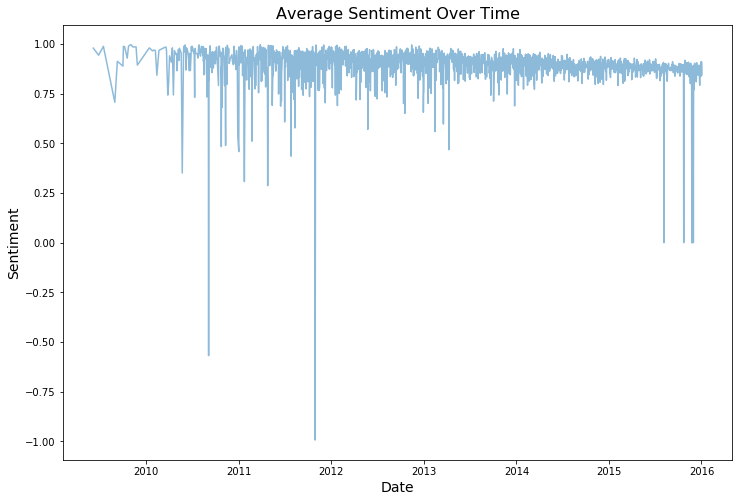

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(seattle_reviews.groupby(by='date')['polarity'].mean(), alpha=0.5)
plt.title('Average Sentiment Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.show()

In [67]:
sort_seattle_reviews = seattle_reviews.sort_values(by='polarity')
sort_seattle_reviews.reset_index(drop=True, inplace=True)

In [68]:
sort_seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,258571,37845285,2015-07-11,31512581,Ysett,Wir sind 5 Nächte geblieben. Und es ist eine A...,-0.9975
1,1018204,5122651,2013-06-13,6775393,Heidi,"leider war esnicht so fein, da die unterkunft ...",-0.9970
2,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",-0.9961
3,3291777,14760768,2014-06-25,16881604,Annar,Melissa replied to our request and approved bu...,-0.9956
4,1775016,21243349,2014-10-13,20072109,Anna,Staying at Robert’s place was a nightmare. At ...,-0.9941


In [69]:
sort_seattle_reviews.tail()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
84826,1048798,18062943,2014-08-21,5244721,Barb,If you are looking for a fabulous place to sta...,0.9994
84827,585418,30257274,2015-04-19,26386980,Victor,"Angela TOTALLY lived up to her ""reputation"" in...",0.9995
84828,5272327,50488125,2015-10-12,363242,Mika,This was such a great trip and experience!\r\n...,0.9995
84829,1048798,41201991,2015-08-05,31934586,Sandy,This was our third trip to Seattle to visit ou...,0.9995
84830,4429898,23827888,2014-12-11,13997957,Aindrea,Awesome location about a mile from downtown Ba...,0.9997


In [70]:
negative = sort_seattle_reviews[:849]
negative.tail()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
844,254340,14390095,2014-06-18,1400390,June,I have stayed here several times and each time...,-0.0102
845,5021969,48469891,2015-09-26,36582242,Arturo,"Experience was Good overall, the building is o...",-0.0096
846,5078244,30113047,2015-04-17,1503536,Tjark,Alberto was a very nice and helpful host. The ...,-0.0056
847,1198884,44676482,2015-08-28,39880231,Tommy,Very nice place. Really close to the conventio...,-0.0031
848,1097520,17511822,2014-08-13,58602,Julia,very nice place. a few things that went wrong...,-0.0018


In [71]:
sort_seattle_reviews[7998:8008]

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
7998,279063,36069664,2015-06-24,33500132,Jenny,Very good staying here. Quiet and convenient. ...,0.7496
7999,5261239,53944294,2015-11-14,20971142,Meghann,Was very easy to access the apartment. Very go...,0.7496
8000,1171574,29509679,2015-04-08,2772734,Shane,I loved staying here! Phil was so accommodatin...,0.7497
8001,3424991,42392677,2015-08-13,31991777,Seth,Great location and good price. I never met Mi...,0.7497
8002,1450262,37939534,2015-07-12,11106271,Eric,"My family and I stayed at Sarah's house twice,...",0.7498
8003,47196,231120,2011-04-18,506322,Timothy,Faye & I found Shalini & Eric's ground floor s...,0.7500
8004,7710713,47839279,2015-09-21,43814436,Francis,Everything was perfect and we felt welcomed in...,0.7500
8005,6482409,45670933,2015-09-05,36678106,Jim,Made the reservation after reading other revie...,0.7500
8006,2263643,50999663,2015-10-16,6791976,Marius,"Tessa is a wonderful host, I felt welcomed and...",0.7500
8007,2686374,54863290,2015-11-25,6287817,Stephan,I had a group of 4 people stay here for a long...,0.7500


In [72]:
sub_pt75 = sort_seattle_reviews[:8003]
top_pt75 = sort_seattle_reviews[8003:]

## All Reviews Graphically

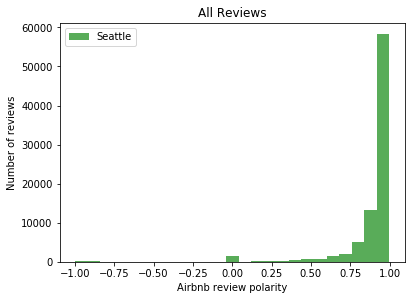

In [73]:
plt.hist(seattle_reviews.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.title('All Reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

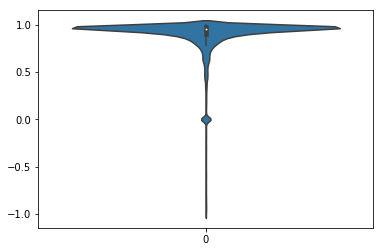

In [74]:
sns.violinplot(data = seattle_reviews.polarity);

## All Reviews with Negative Sentiment

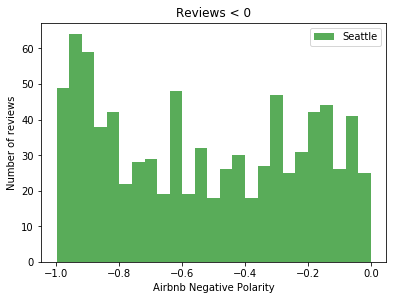

In [75]:
plt.hist(negative.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Negative Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment < 0.75

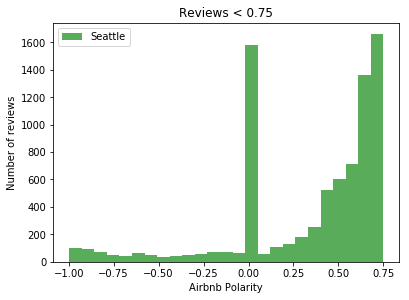

In [76]:
plt.hist(sub_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment >= 0.75

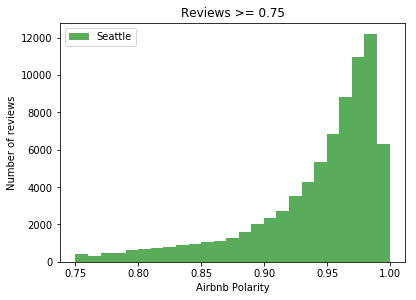

In [77]:
plt.hist(top_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews >= 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

# Now Need to Find Which Locations Received Poor Reviews

In [78]:
print("Number of Negatively Reviewed Air BnB Locations:", negative.listing_id.nunique())
# Create list of 'IDs' for Negative Reviews
negative_locs = list(negative.listing_id.unique())

Number of Negatively Reviewed Air BnB Locations: 559


In [79]:
print("Number of Locations Reviewed <0.75:", sub_pt75.listing_id.nunique())
sub_75_locs = list(sub_pt75.listing_id.unique())

Number of Locations Reviewed <0.75: 2037


In [80]:
print("Number of Locations Reviewed >0.75:", top_pt75.listing_id.nunique())
top_75_locs = list(top_pt75.listing_id.unique())

Number of Locations Reviewed >0.75: 3134


In [81]:
print("Total Number of Locations:", seattle_reviews.listing_id.nunique())
all_locs = list(seattle_reviews.listing_id.unique())

Total Number of Locations: 3191


In [82]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [83]:
negs = listings[['id', 'latitude', 'longitude']]
neg_ids = negative_locs
neg_dict = {}
for neg in neg_ids:
    df = negs.loc[negs['id'] == neg]
    neg_dict[neg] = {}
    neg_dict[neg]['lat'] = (df['latitude'])
    neg_dict[neg]['long'] = (df['longitude'])

In [84]:
lists_map = listings[['id', 'host_name', 'latitude', 'longitude', 'price', 'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                      'review_scores_location', 'review_scores_value']]
lists_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 12 columns):
id                             3818 non-null int64
host_name                      3816 non-null object
latitude                       3818 non-null float64
longitude                      3818 non-null float64
price                          3818 non-null object
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 358.0+ KB


In [85]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


In [86]:
seattle_reviews.rename(columns={"id": "review_id", "listing_id": "id"}, inplace=True)

In [87]:
seattle_reviews.head(20)

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783
5,7202016,43979139,2015-08-23,1154501,Barent,"Kelly was great, place was great, just what I ...",0.9349
6,7202016,45265631,2015-09-01,37853266,Kevin,Kelly was great! Very nice and the neighborhoo...,0.9421
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz - Just left Seattle where I h...,0.9671
8,7202016,47783346,2015-09-21,249583,Todd,Kelly's place is conveniently located on a qui...,0.5562
9,7202016,48388999,2015-09-26,38110731,Tatiana,"The place was really nice, clean, and the most...",0.8613


In [88]:
lists_map['price'] = lists_map['price'].fillna('$0.00')
lists_map['price'] = lists_map['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

In [89]:
seattle_reviews['latitude'] = np.zeros(len(seattle_reviews))
seattle_reviews['longitude'] = np.zeros(len(seattle_reviews))
seattle_reviews['price'] = np.zeros(len(seattle_reviews))

In [90]:
seattle_reviews.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,0.0,0.0,0.0
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,0.0,0.0,0.0
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,0.0,0.0,0.0
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,0.0,0.0,0.0
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,0.0,0.0,0.0


In [91]:
len(seattle_reviews)

84831

In [94]:
if not os.path.exists('seattle_reviews2.h5'):
    count = 0
    start = timer()
    current = timer()
    latitude = []
    longitude = []
    price = []
    start = timer()
    for i in range(len(seattle_reviews)):
        df = seattle_reviews.iloc[i]
        index = df['id']
        latitude.append(float(lists_map[lists_map['id'] == index]['latitude'].values))
        longitude.append(float(lists_map[lists_map['id'] == index]['longitude'].values))
        price.append(float(lists_map[lists_map['id'] == index]['price'].values))
        count += 1
        if count % 500 == 0:
            print("Step {} / 169".format(int(count/500)))
            step = count/500
            current = timer()
            elapsed = round(current - start, 3)
            average = elapsed / step
            remaining = round((average*(169 - count/500)/60), 3)
            if elapsed < 60:
                print("Time elapsed: {} seconds".format(elapsed))
                print("Time remaining: {} minutes".format(remaining))
            else:
                print("Time elapsed: {} minutes".format(round(elapsed/60, 3)))
                print("Time remaining: {} minutes".format(remaining))
            print()
    seattle_reviews['latitude'] = latitude
    seattle_reviews['longitude'] = longitude
    seattle_reviews['price'] = price
seattle_reviews.to_hdf('seattle_reviews2.h5', key='seattle_reviews2', mode='w')

Step 1 / 169
Time elapsed: 0.877 seconds
Time remaining: 2.456 minutes

Step 2 / 169
Time elapsed: 1.735 seconds
Time remaining: 2.415 minutes

Step 3 / 169
Time elapsed: 2.564 seconds
Time remaining: 2.365 minutes

Step 4 / 169
Time elapsed: 3.423 seconds
Time remaining: 2.353 minutes

Step 5 / 169
Time elapsed: 4.399 seconds
Time remaining: 2.405 minutes

Step 6 / 169
Time elapsed: 5.344 seconds
Time remaining: 2.42 minutes

Step 7 / 169
Time elapsed: 6.204 seconds
Time remaining: 2.393 minutes

Step 8 / 169
Time elapsed: 7.559 seconds
Time remaining: 2.535 minutes

Step 9 / 169
Time elapsed: 8.728 seconds
Time remaining: 2.586 minutes

Step 10 / 169
Time elapsed: 9.924 seconds
Time remaining: 2.63 minutes

Step 11 / 169
Time elapsed: 10.818 seconds
Time remaining: 2.59 minutes

Step 12 / 169
Time elapsed: 11.712 seconds
Time remaining: 2.554 minutes

Step 13 / 169
Time elapsed: 12.659 seconds
Time remaining: 2.532 minutes

Step 14 / 169
Time elapsed: 13.618 seconds
Time remaining: 2

Step 113 / 169
Time elapsed: 1.73 minutes
Time remaining: 0.857 minutes

Step 114 / 169
Time elapsed: 1.745 minutes
Time remaining: 0.842 minutes

Step 115 / 169
Time elapsed: 1.759 minutes
Time remaining: 0.826 minutes

Step 116 / 169
Time elapsed: 1.774 minutes
Time remaining: 0.81 minutes

Step 117 / 169
Time elapsed: 1.788 minutes
Time remaining: 0.795 minutes

Step 118 / 169
Time elapsed: 1.803 minutes
Time remaining: 0.779 minutes

Step 119 / 169
Time elapsed: 1.817 minutes
Time remaining: 0.764 minutes

Step 120 / 169
Time elapsed: 1.831 minutes
Time remaining: 0.748 minutes

Step 121 / 169
Time elapsed: 1.846 minutes
Time remaining: 0.732 minutes

Step 122 / 169
Time elapsed: 1.86 minutes
Time remaining: 0.717 minutes

Step 123 / 169
Time elapsed: 1.875 minutes
Time remaining: 0.701 minutes

Step 124 / 169
Time elapsed: 1.889 minutes
Time remaining: 0.686 minutes

Step 125 / 169
Time elapsed: 1.904 minutes
Time remaining: 0.67 minutes

Step 126 / 169
Time elapsed: 1.918 minutes

In [95]:
seattle_reviews = pd.read_hdf('seattle_reviews2.h5', 'seattle_reviews2')
seattle_reviews.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0


# Now that we have the Reviews' Polarity, Latitude, Longitude, and Price:
### Let's try and plot a Folium choropleth or heatmap showing good and bad reviews

In [101]:
crime_df = pd.read_csv('Data/seattle_crime/Seattle_Police_Department_911_Incident_Response.csv')

In [102]:
drops = crime_df.columns[15:]
crime_df.isna().sum()
crime_df.drop(columns=drops, inplace=True)
crime_df.dropna(inplace=True)

In [104]:
crime = crime_df[['Event Clearance Group', 'Event Clearance Description', 'Event Clearance Date', 'District/Sector', 
                'Zone/Beat', 'Latitude', 'Longitude', 'Incident Location']]
crime.head()

,Event Clearance Group,Event Clearance Description,Event Clearance Date,District/Sector,Zone/Beat,Latitude,Longitude,Incident Location
0,DISTURBANCES,FIGHT DISTURBANCE,07/17/2010 08:49:00 PM,M,M2,47.610975,-122.338147,"(47.610975163, -122.338146748)"
1,OTHER PROPERTY,THEFT - MISCELLANEOUS,07/17/2010 08:50:00 PM,Q,Q1,47.658325,-122.404613,"(47.658324899, -122.404612874)"
2,"NUISANCE, MISCHIEF","MISCHIEF, NUISANCE COMPLAINTS",07/17/2010 08:55:00 PM,M,M2,47.613551,-122.342843,"(47.613551471, -122.342843234)"
3,TRAFFIC RELATED CALLS,TRAFFIC (MOVING) VIOLATION,07/17/2010 09:00:00 PM,D,D1,47.625401,-122.341847,"(47.625401388, -122.341846999)"
4,"NUISANCE, MISCHIEF","MISCHIEF, NUISANCE COMPLAINTS",07/17/2010 09:00:00 PM,D,D1,47.627425,-122.339709,"(47.627424837, -122.339708605)"


In [105]:
locations = crime[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
print(len(locationlist))
locationlist[:5]

1415994


[[47.610975163, -122.33814674799999],
 [47.65832489899999, -122.404612874],
 [47.613551471, -122.342843234],
 [47.625401388, -122.341846999],
 [47.627424837, -122.339708605]]

In [124]:
crime_clusters=folium.Map(location=[crime.Latitude.mean(),crime.Longitude.mean()],
                          zoom_start=11,tiles='OpenStreetMap')
plugins.FastMarkerCluster(locationlist).add_to(crime_clusters)
plugins.ScrollZoomToggler().add_to(crime_clusters)
crime_clusters.save(os.path.join('Maps/', 'crime_clusters.html'))

In [113]:
zones = crime_df[['Zone/Beat', 'District/Sector', 'Latitude', 'Longitude']]
zones.head()

,Zone/Beat,District/Sector,Latitude,Longitude
0,M2,M,47.610975,-122.338147
1,Q1,Q,47.658325,-122.404613
2,M2,M,47.613551,-122.342843
3,D1,D,47.625401,-122.341847
4,D1,D,47.627425,-122.339709


In [114]:
zones.dropna(inplace=True)

In [115]:
print(zones['District/Sector'].unique())
zlist = list(zones['District/Sector'].unique())

['M' 'Q' 'D' 'R' 'U' 'K' 'N' 'S' 'F' 'J' 'L' 'W' 'E' 'C' 'G' 'B' 'O' '99'
 'H']


In [116]:
zones[zones['Zone/Beat'] == 'M2'].head()

,Zone/Beat,District/Sector,Latitude,Longitude
0,M2,M,47.610975,-122.338147
2,M2,M,47.613551,-122.342843
37,M2,M,47.613343,-122.338524
78,M2,M,47.611706,-122.338048
92,M2,M,47.612887,-122.343703


In [117]:
zones.isna().sum()

Zone/Beat          0
District/Sector    0
Latitude           0
Longitude          0
dtype: int64

In [119]:
crime_groups = list(crime_df['Event Clearance Group'].unique())
print("There are", len(crime_groups), "different types of Crime in Seattle")
districts = crime_df['District/Sector'].unique()
print("There are", len(districts), "different Districts in Seattle")
print("There are", len(crime_df), "total Crimes committed in Seattle")

There are 44 different types of Crime in Seattle
There are 19 different Districts in Seattle
There are 1415994 total Crimes committed in Seattle


In [120]:
crimes_dict = {}
for district in districts:
    df = crime_df[crime_df['District/Sector'] == district]
    total = len(df)
    crimes_dict[district] = {}
    top_5 = df['Event Clearance Group'].value_counts().nlargest(5).to_dict()
    crimes_dict[district]["top_5"] = ""
    for key in top_5.keys():
        percent = round((top_5[key] / total)*100, 3)
        crimes_dict[district]["top_5"] += "{} = {} percent of Crime, ".format(
            key.title(), percent)
#         crimes_dict[district]["top_5"] += "\n"


In [121]:
z_dict = {}
for z in zlist:
    df = zones.loc[zones['District/Sector'] == z]
    z_dict[z] = {}
    z_dict[z]['Lat'] = (df['Latitude'].mean())
    z_dict[z]['Long'] = (df['Longitude'].mean())
    z_dict[z]["Top 5"] = crimes_dict[z]["top_5"]

In [128]:
seattle_geo = '/Users/steeznation/Flatiron/Module05/capstone/seattle-boundaries-data/data/spd-beats.geojson'

seattle_coords = (47.6062, -122.3321)

# definition of the boundaries in the map
district_geo = seattle_geo
  
# calculating total number of incidents per district
crimedata = pd.DataFrame(crime_df['Zone/Beat'].value_counts().astype(float))
crimedata.to_json('crimeagg.json')
crimedata = crimedata.reset_index()
crimedata.columns = ['Beat', 'Number']

m = folium.Map(location=seattle_coords, zoom_start=11)
folium.Choropleth(geo_data=seattle_geo,
                  data=crimedata,
                  columns=['Beat', 'Number'],
                  key_on='feature.properties.name',
                  fill_color='YlGnBu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  bins=9,
                  name='Incidents per Beat',
                  legend_name='Incidents per Beat',
                  highlight=True).add_to(m)

for k, v in (z_dict.items()):
    # print(k, list([v['Lat'], v['Long']]))
    folium.Marker([v['Lat'], v['Long']], popup=folium.Popup(v["Top 5"], max_width=150), 
                  tooltip=("District: "+str(k))).add_to(m)
plugins.MarkerCluster(locationlist, name='Crime Clusters').add_to(m)
folium.LayerControl().add_to(m)
plugins.ScrollZoomToggler().add_to(m)

m.save(os.path.join('Maps/', 'crime_districts.html'))
m

KeyboardInterrupt: 

In [159]:
seattle_reviews[:16].groupby('id').head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0


In [193]:
lists_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 12 columns):
id                             3818 non-null int64
host_name                      3816 non-null object
latitude                       3818 non-null float64
longitude                      3818 non-null float64
price                          3818 non-null float64
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 358.0+ KB


In [211]:
polaritydata = (seattle_reviews.groupby(by='id')['polarity'].mean().astype(float))
type(polaritydata)

pandas.core.series.Series

In [54]:
from folium import plugins
from folium.plugins import HeatMap


map_hooray = folium.Map(location=[47.6062, -122.3321],
                    zoom_start = 11) 

# Ensure you're handing it floats
lists_map['latitude'] = lists_map['latitude'].astype(float)
lists_map['longitude'] = lists_map['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = lists_map[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])

# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, min_opacity=0.5, radius=15).add_to(map_hooray)
plugins.ScrollZoomToggler().add_to(map_hooray)

# Display the map
map_hooray.save('Maps/map_hooray.html')
map_hooray

NameError: name 'lists_map' is not defined

In [132]:
seattle_geo = '/Users/steeznation/Flatiron/Module05/capstone/seattle-boundaries-data/data/city-limits.geojson'

seattle_coords = (47.6062, -122.3321)

# definition of the boundaries in the map
district_geo = seattle_geo
  
# calculating total number of incidents per district
airbnbdata = pd.DataFrame(seattle_reviews['polarity'].value_counts().astype(float))
airbnbdata.to_json('airbnbdata.json')
airbnbdata = airbnbdata.reset_index()
airbnbdata.columns = ['latitude', 'longitude']

m = folium.Map(location=seattle_coords, zoom_start=11)
folium.Choropleth(geo_data=seattle_geo,
                  data=crimedata,
                  columns=['Beat', 'Number'],
                  key_on='feature.properties.name',
                  fill_color='YlGnBu',
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  bins=9,
                  name='Incidents per Beat',
                  legend_name='Incidents per Beat',
                  highlight=True).add_to(m)

KeyError: ('latitude', 'longitude')